# DATA 512: Homework 1

The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from January 1, 2015 through September 30, 2022. Your notebook(s) and your data files will be uploaded to a repository of your choosing. You will submit a  link to your repository to enable grading of this assignment. The purpose of the assignment is to develop and follow best practices for open scientific research.

# Setup

In [1]:
import pandas as pd
import json, time, urllib.parse
import requests
import seaborn as sns
import re

# Step 1: Data Acquisition

In order to measure article traffic from 2015-2022, you will need to collect data from the Pageviews API. The Pageviews API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month.

To get you started, you can refer to [this example notebook](https://drive.google.com/file/d/1gtFZAjRoOShsqZKuNhiiSn9Ko4ky-CSC/view?usp=sharing) that contains sample code for the API call. This sample code is licensed CC0 so feel free to reuse any of the code in that notebook without attribution.

You will be collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of [dinosaur related articles](https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/edit?usp=sharing). You will use the same article subset to generate several related data sets. All of the data sets are time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. 

The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. You should store the time series data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.
You will produce three files as follows:
- Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called: `dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json`
- Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called: `dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json`
- Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called: `dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json`

For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text.


## 1.1 Wikimedia Page Views API starter code

The example relies on some constants that help make the code a bit more readable.

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<hbaghar@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # Start date 01 July 2015
    "end":         "2022093000"    # End date 30 September 2022
}


In [3]:
# Yearmonth dates for the start and end of the data collection period
START_DATE_YM = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'][:-4]
END_DATE_YM = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end'][:-4]

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [4]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [5]:
print("Getting pageview data for: ",ARTICLE_TITLES[1])
views = request_pageviews_per_article(ARTICLE_TITLES[1])

Getting pageview data for:  Northern flicker


In [6]:
views

{'items': [{'project': 'en.wikipedia',
   'article': 'Northern_flicker',
   'granularity': 'monthly',
   'timestamp': '2015070100',
   'access': 'desktop',
   'agent': 'user',
   'views': 4018},
  {'project': 'en.wikipedia',
   'article': 'Northern_flicker',
   'granularity': 'monthly',
   'timestamp': '2015080100',
   'access': 'desktop',
   'agent': 'user',
   'views': 3116},
  {'project': 'en.wikipedia',
   'article': 'Northern_flicker',
   'granularity': 'monthly',
   'timestamp': '2015090100',
   'access': 'desktop',
   'agent': 'user',
   'views': 4802},
  {'project': 'en.wikipedia',
   'article': 'Northern_flicker',
   'granularity': 'monthly',
   'timestamp': '2015100100',
   'access': 'desktop',
   'agent': 'user',
   'views': 5373},
  {'project': 'en.wikipedia',
   'article': 'Northern_flicker',
   'granularity': 'monthly',
   'timestamp': '2015110100',
   'access': 'desktop',
   'agent': 'user',
   'views': 4954},
  {'project': 'en.wikipedia',
   'article': 'Northern_flicker

In [7]:
#print(json.dumps(views,indent=4))
print("Have %d months of pageview data"%(len(views['items'])))
for month in views['items']:
    print(json.dumps(month,indent=4))

Have 87 months of pageview data
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015070100",
    "access": "desktop",
    "agent": "user",
    "views": 4018
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015080100",
    "access": "desktop",
    "agent": "user",
    "views": 3116
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015090100",
    "access": "desktop",
    "agent": "user",
    "views": 4802
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015100100",
    "access": "desktop",
    "agent": "user",
    "views": 5373
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015110100",
    "access": "desktop",
    "agent": "user",
    "views": 

## 1.2 Fetch Dinosaur Data Using API Starter Code

### 1.2.1 Fetch dinosaur names

We read the dinosaur names from the specified google sheet and clean some of the special characters that were observed

In [8]:
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/export?gid=1345871712&format=csv'
DINO_ARTICLE_NAMES = [re.sub(r'“|”','',name) for name in pd.read_csv(SHEET_URL)['name'].to_list()] # remove quotes from names

In [9]:
DINO_ARTICLE_NAMES[:5]

['Coelosaurus antiquus',
 'Aachenosaurus',
 'Aardonyx',
 'Abdarainurus',
 'Abditosaurus']

### 1.2.2 Fetch and store desktop views

For each dinosaur, hit the API endpoint with desktop as the access type and store the result in a JSON file. The JSON file will be an array of dinosaurs and each element consists of an array of timeseries JSON objects.

In [10]:
results_desktop = []
for name in DINO_ARTICLE_NAMES:
    dino_hits = request_pageviews_per_article(name)["items"]
    for item in dino_hits:
        del item["access"] #delete access key from dictionary
    results_desktop.append(dino_hits)
with open(f"dino_monthly_desktop_start{START_DATE_YM}-end{END_DATE_YM}.json", "w") as file:
    file.write(json.dumps(results_desktop, indent=4))

### 1.2.3 Fetch and store mobile views

Repeat the same steps for mobile-app and mobile-web access. First we modify the params template

In [11]:
MOBILE_APP_PAGEVIEW_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # Start date 01 July 2015
    "end":         "2022093000"    # End date 30 September 2022
}

In [12]:
MOBILE_WEB_PAGEVIEW_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # Start date 01 July 2015
    "end":         "2022093000"    # End date 30 September 2022
}

Then we load each of the web and app views, and sum up the results into a single JSON object for each point in the time series

In [13]:
results_mobile = []
for name in DINO_ARTICLE_NAMES:
    dino_hits_app = request_pageviews_per_article(name, request_template=MOBILE_APP_PAGEVIEW_PARAMS_TEMPLATE)["items"]
    dino_hits_web = request_pageviews_per_article(name, request_template=MOBILE_WEB_PAGEVIEW_PARAMS_TEMPLATE)["items"]
    dino_hits = []
    for app_item,web_item in zip(dino_hits_app, dino_hits_web):
        del app_item["access"] #delete access key from dictionary
        del web_item["access"] #delete access key from dictionary
        combined_item = app_item.copy()
        combined_item["views"] = app_item["views"] + web_item["views"] #combining mobile app and mobile web views
        dino_hits.append(combined_item)
    results_mobile.append(dino_hits)

with open(f"dino_monthly_mobile_start{START_DATE_YM}-end{END_DATE_YM}.json", "w") as file:
    file.write(json.dumps(results_mobile, indent=4))

### 1.2.3 Fetch and store cumulative views

We iterate through the desktop and mobioe views and cumulatively add each of the views to each point in the time series using the `cumulative` variable inside the outer loop. This variable resets to 0 each time we iterate over the results to a new dinosaur.

In [30]:
results_cumulative = []

for mobile,desktop in zip(results_mobile, results_desktop):
    dino_hits = []
    cumulative = 0
    for mobile_item,desktop_item in zip(mobile, desktop):
        combined_item = mobile_item.copy()
        combined_item["views"] = cumulative + mobile_item["views"] + desktop_item["views"] #combining mobile and desktop views
        cumulative = combined_item["views"]
        dino_hits.append(combined_item)
    results_cumulative.append(dino_hits)

with open(f"dino_monthly_cumulative_start{START_DATE_YM}-end{END_DATE_YM}.json", "w") as file:
    file.write(json.dumps(results_cumulative, indent=4))

# Step 2: Analysis

You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.

In [15]:
# Loading everything into a pandas dataframe to make it easier to work with
def create_dataframe(results):
    views = pd.DataFrame(columns=['project', 'article', 'granularity', 'timestamp', 'agent','views'])
    for dino in results:
        views = pd.concat([views,pd.DataFrame(dino)])
    views['timestamp'] = pd.to_datetime(views['timestamp'], format='%Y%m%d%H')
    return views

views_desktop = create_dataframe(json.loads(open(f"dino_monthly_desktop_start{START_DATE_YM}-end{END_DATE_YM}.json", "r").read()))
views_mobile = create_dataframe(json.loads(open(f"dino_monthly_mobile_start{START_DATE_YM}-end{END_DATE_YM}.json", "r").read()))
views_cumulative = create_dataframe(json.loads(open(f"dino_monthly_cumulative_start{START_DATE_YM}-end{END_DATE_YM}.json", "r").read()))

In [16]:
views_desktop.shape, views_mobile.shape, views_cumulative.shape

((112697, 6), (112697, 6), (112697, 6))

## 2.1 Max and min average

The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

First aggregate views to mean for each dinosaur

In [17]:
desktop_agg = views_desktop.groupby('article')["views"].agg({'mean'})
mobile_agg = views_mobile.groupby('article')["views"].agg({'mean'})

Then find the lowest and highest values in the dataframe and the corresponding dinosaurs

In [18]:
min_and_max_dinos_desktop = desktop_agg[(desktop_agg['mean'] == desktop_agg["mean"].min()) | (desktop_agg['mean'] == desktop_agg["mean"].max())]
min_and_max_dinos_desktop

,mean
article,
Honghesaurus,16.965517
Tyrannosaurus,46406.000000


In [19]:
min_and_max_dinos_mobile = mobile_agg[(mobile_agg['mean'] == mobile_agg["mean"].min()) | (mobile_agg['mean'] == mobile_agg["mean"].max())]
min_and_max_dinos_mobile

,mean
article,
Honghesaurus,5.885057
Tyrannosaurus,59537.701149


Nowm extract the entire time series for the dinosaurs identified in the previous step

In [20]:
min_max_desktop = views_desktop[views_desktop['article'].isin(min_and_max_dinos_desktop.index)]
min_max_desktop = min_max_desktop.assign(access='desktop')
min_max_mobile = views_mobile[views_mobile['article'].isin(min_and_max_dinos_mobile.index)]
min_max_mobile = min_max_mobile.assign(access='mobile')

min_max_df = pd.concat([min_max_desktop,min_max_mobile])
min_max_df

,project,article,granularity,timestamp,agent,views,access
0,en.wikipedia,Honghesaurus,monthly,2015-07-01,user,23,desktop
1,en.wikipedia,Honghesaurus,monthly,2015-08-01,user,13,desktop
2,en.wikipedia,Honghesaurus,monthly,2015-09-01,user,27,desktop
3,en.wikipedia,Honghesaurus,monthly,2015-10-01,user,16,desktop
4,en.wikipedia,Honghesaurus,monthly,2015-11-01,user,10,desktop
...,...,...,...,...,...,...,...
82,en.wikipedia,Tyrannosaurus,monthly,2022-05-01,user,68130,mobile
83,en.wikipedia,Tyrannosaurus,monthly,2022-06-01,user,116521,mobile
84,en.wikipedia,Tyrannosaurus,monthly,2022-07-01,user,88247,mobile
85,en.wikipedia,Tyrannosaurus,monthly,2022-08-01,user,72021,mobile


Lastly, plot the results

Text(0.5, 1.0, 'Monthly page views for the most and least popular dinosaurs')

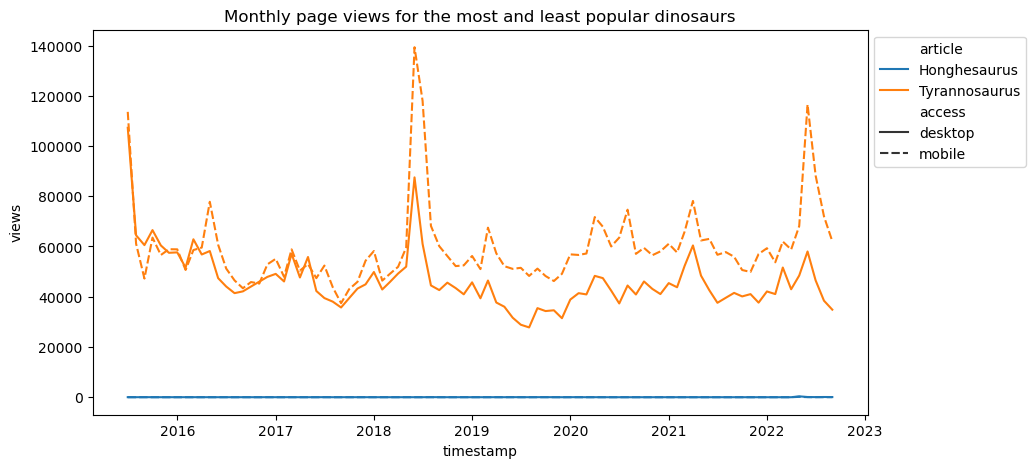

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=min_max_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.title("Monthly page views for the most and least popular dinosaurs")

## 2.2 Top 10 Peak Page Views

The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).


To identify top 10 dinosaurs with largest peak page views we identify the peaks for each dinosaur using `max` on the `views` variable. Following which we sort in descending order and get the first 10 names

In [22]:
top_10_dinos_desktop = views_desktop.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)
top_10_dinos_desktop

article
Achelousaurus     205150
Velociraptor      135741
Tyrannosaurus     107257
Halszkaraptor     103251
Giganotosaurus     62340
Spinosaurus        61029
Lythronax          57701
Nigersaurus        57192
Borealopelta       53831
Dilophosaurus      53278
Name: views, dtype: int64

In [23]:
top_10_dinos_mobile = views_mobile.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)
top_10_dinos_mobile

article
Nigersaurus        235977
Deinocheirus       234704
Giganotosaurus     165007
Therizinosaurus    155431
Velociraptor       142284
Achelousaurus      140592
Tyrannosaurus      139326
Borealopelta       117282
Dilophosaurus       78537
Argentinosaurus     78437
Name: views, dtype: int64

Now, extract the entire time series for the dinosaurs identified in the above step.

In [24]:
top_10_desktop = views_desktop[views_desktop['article'].isin(top_10_dinos_desktop.index)]
top_10_desktop = top_10_desktop.assign(access='desktop')
top_10_mobile = views_mobile[views_mobile['article'].isin(top_10_dinos_mobile.index)]
top_10_mobile = top_10_mobile.assign(access='mobile')

top_10_df = pd.concat([top_10_desktop,top_10_mobile])

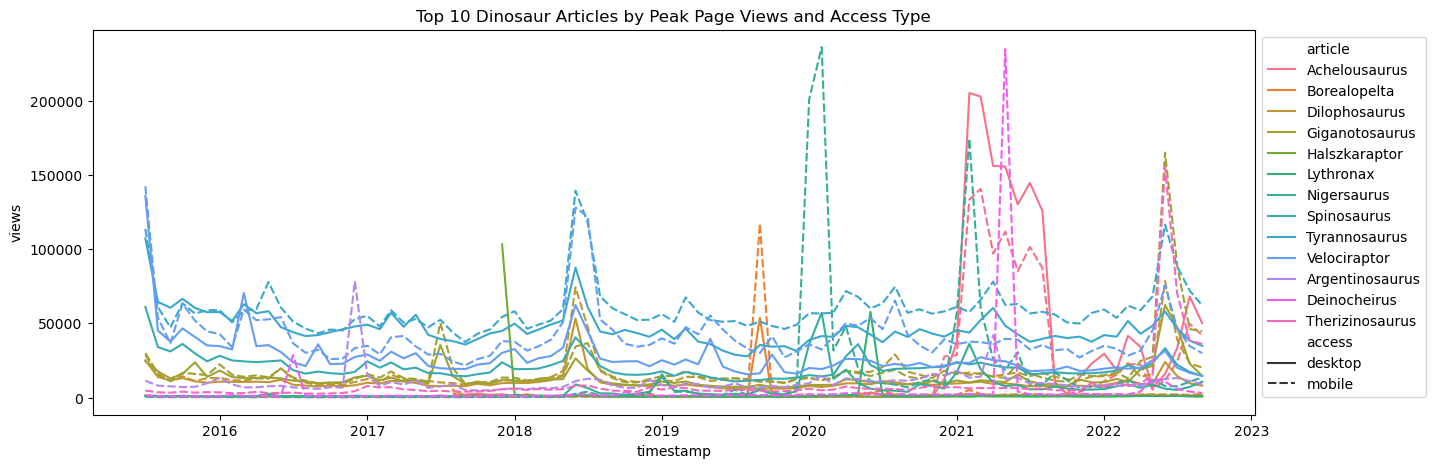

In [25]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=top_10_df, legend='full');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Top 10 Dinosaur Articles by Peak Page Views and Access Type");

## 2.3 Fewest Months of Data

The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


We count the number of rows for each dinosaur, sort in ascending order and selet the first 10 dinosaurs.

In [26]:
desktop_fewest_dinos = views_desktop.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)
desktop_fewest_dinos

article
Elemgasem                1
Tuebingosaurus           1
Jakapil                  2
Mbiresaurus              2
Perijasaurus             2
Bisticeratops            2
Iyuku                    3
Paralitherizinosaurus    5
Bashanosaurus            7
Dzharaonyx               7
Name: views, dtype: int64

In [27]:
mobile_fewest_dinos = views_mobile.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)
mobile_fewest_dinos

article
Elemgasem                1
Tuebingosaurus           1
Jakapil                  2
Mbiresaurus              2
Perijasaurus             2
Bisticeratops            2
Iyuku                    3
Paralitherizinosaurus    5
Bashanosaurus            7
Dzharaonyx               7
Name: views, dtype: int64

Then, we extract the entire time series for each of the dinosaurs identified above.

In [28]:
fewest_desktop = views_desktop[views_desktop['article'].isin(desktop_fewest_dinos.index)]
fewest_desktop = fewest_desktop.assign(access='desktop')
fewest_mobile = views_mobile[views_mobile['article'].isin(mobile_fewest_dinos.index)]
fewest_mobile = fewest_mobile.assign(access='mobile')

fewest_df = pd.concat([fewest_desktop,fewest_mobile])

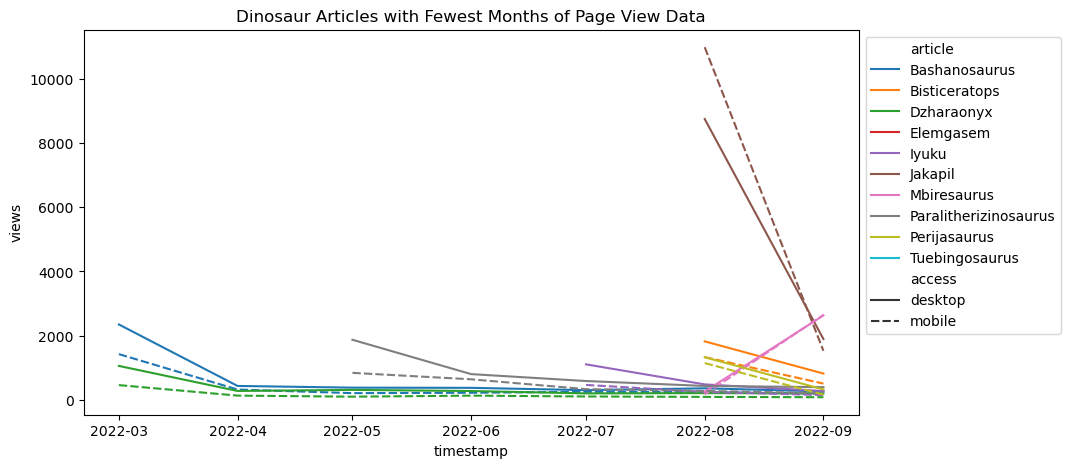

In [29]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=fewest_df, legend='full');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dinosaur Articles with Fewest Months of Page View Data");